Github repository URL: https://github.com/kalichore/DMHRAssignment

In [1]:
#add libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from pandasql import PandaSQL
from scipy.stats import linregress
from pandas import Series
from matplotlib import pyplot




# Functions
User defined unctions used throughout he workbook will be contained in this section. These functions ave been designed to minimise repeated code, and for re-use throughout the notebook.

## get_data function
The get_data function was created for two purposes:
1. To import the datasets and apply the same data cleaning steps to each dataset as they were imported (setting data items to lower case and removing trailing spaces)
2. Handle connection errors while importing the dataset. It was noted that the Amazon Web Servers would frequently terminate the connection, particularly when attemptimg to load the prescribing dataset. The function allows the user to define a number of reconnection attempts (default 5) before ending the import process, and if the process is termintaed, informs the user of the number of attempts made and the reason the import failed.

In addition to defining the maximum number of connection attempts, the URL or file location of a dataset are passed to the function, and optionally headers can be defined for datasets without header.

In [2]:
#Function to import datasets with optional parameters to define headings and maximum number of connection attempts.
def get_data(url, hnames=None, max_try=5):
    count = 1
    while count <= max_try: 
        try:
            if hnames==None:
                
            #print header, names #, index_col, max_try
                #print hnames
                df = pd.read_csv((url), engine='python')
                df.columns = [x.strip().replace(' ', '') for x in df.columns]
                for col in df.columns:
                    if df[col].dtype.kind == "O":
                        df[col] = df[col].astype(str).map(lambda x: x.strip())
                        df[col]=df[col].astype(str).map(lambda x: x.lower())
                    #print "Data read and cleaned after", count, " attempt(s)"
                return df
                break
            else:
                #print hnames
                df = pd.read_csv(url, names=hnames, index_col=False, engine='python')
                df.columns = [x.strip().replace(' ', '') for x in df.columns]
                for col in df.columns:
                    if df[col].dtype.kind == "O":
                        df[col] = df[col].astype(str).map(lambda x: x.strip())
                        df[col]=df[col].astype(str).map( lambda x: x.lower())
                    #print "Data read and cleaned after", count, " attempt(s)"
                return df
                break
        except:
            print "Attempt ", count, ": Unexpected error: ", sys.exc_info()[0]
            if count == max_try:
                print "Data not loaded"
            count += 1 

## prescribing_by_LA
The prescribing_by_LA function allows the merged GP and prescribing dataset to be subset by a lcoal authority name passed by the user. The GP Practice postcodes are used to determine whoch local authority/city the practice belongs to.

In [3]:
#Function to subset merged data frame based on local authority name passed by user
def prescribing_by_LA(LA):
    #Subset postcode data for the lcoal authority passed to the function
    pc=postcodes[postcodes.LocalAuthorityName==LA]
    #Return postcodes for local authority as a list
    ons_postcode=pc.Postcode1.unique().tolist()

    #subset the merged GP and prescribng dataset to return data related to GP practices in the named local authority area only only
    df=prescribing_GP_LA[prescribing_GP_LA.Postcode.isin(ons_postcode)]
    return df

# Datasets
Import, describe and merge where appropriate the prescribing, GP Practice, GP Practice Demographics and Postcode datasets.

In [4]:
#import the full prescribing data frame
prescribing_data=get_data("https://s3.eu-west-2.amazonaws.com/dmhr-data/prescribing_Dec2015.csv")

In [5]:
#show first 5 rows in prescribing dataset to inspect data
prescribing_data.head()

,SHA,PCT,PRACTICE,BNFCODE,BNFNAME,ITEMS,NIC,ACTCOST,QUANTITY,PERIOD,
0,q44,rjn,y05218,0501013k0aaajaj,co-amoxiclav_tab 500mg/125mg,1,3.59,3.33,21,201512,
1,q44,rjn,y05218,0501130r0aaaaaa,nitrofurantoin_cap 50mg,1,14.39,13.42,28,201512,
2,q44,rtv,y04937,0401020k0aaahah,diazepam_tab 2mg,1,0.51,0.58,14,201512,
3,q44,rtv,y04937,0401020p0aaabab,lorazepam_tab 1mg,1,2.65,2.46,28,201512,
4,q44,rtv,y04937,0402010abaaabab,quetiapine_tab 25mg,2,2.01,2.08,84,201512,


In [6]:
#describe prescribing dataset
prescribing_data.describe()

,ITEMS,NIC,ACTCOST,QUANTITY,PERIOD
count,1.027212e+07,1.027212e+07,1.027212e+07,1.027212e+07,10272116.0
mean,9.354578e+00,7.992544e+01,7.424491e+01,7.569154e+02,201512.0
std,3.145242e+01,2.076790e+02,1.924409e+02,4.264435e+03,0.0
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,201512.0
25%,1.000000e+00,8.820000e+00,8.270000e+00,2.800000e+01,201512.0
50%,2.000000e+00,2.496000e+01,2.321000e+01,1.000000e+02,201512.0
75%,6.000000e+00,7.141000e+01,6.645000e+01,3.600000e+02,201512.0
max,8.004000e+03,9.719064e+04,8.986753e+04,2.052036e+06,201512.0


In [7]:
#Rename PCT column to CCG_CODE so as it reflects actual field
prescribing_data.rename(columns = {'PCT':'CCG_CODE'}, inplace = True)

In [8]:
#Import the gp practice details dataset
#create a list with the dataset headers and pass this to the get_data function
dataset_headers=['YearMonth', 'Practice', 'PracticeName', 'Address1','Address2','Address3','Address4','Postcode']
gp_practice=get_data("https://s3.eu-west-2.amazonaws.com/dmhr-data/practices_Dec2015.csv", hnames=dataset_headers)
#get first five rows of GP Practice dataset
gp_practice.head()

,YearMonth,Practice,PracticeName,Address1,Address2,Address3,Address4,Postcode
0,201512,a81001,the densham surgery,the health centre,lawson street,stockton on tees,cleveland,ts18 1hu
1,201512,a81002,queens park medical centre,queens park medical ctr,farrer street,stockton on tees,cleveland,ts18 2aw
2,201512,a81003,victoria medical practice,the health centre,victoria road,hartlepool,cleveland,ts26 8db
3,201512,a81004,woodlands road surgery,6 woodlands road,,middlesbrough,cleveland,ts1 3be
4,201512,a81005,springwood surgery,springwood surgery,rectory lane,guisborough,,ts14 7dj


In [9]:
#Describe the GP Practice dataset
gp_practice.describe()

,YearMonth
count,9906.0
mean,201512.0
std,0.0
min,201512.0
25%,201512.0
50%,201512.0
75%,201512.0
max,201512.0


In [10]:
#import GP Patient Demographic data
gp_patient_demographics = get_data("https://digital.nhs.uk/media/28273/Numbers-of-Patients-Registered-at-a-GP-Practice-Jan-2016-GP-Practice-and-quinary-age-groups/Any/gp-reg-patients-prac-quin-age.csv")
#first 5 rows in GP Demographic dataset
gp_patient_demographics.head()

,GP_PRACTICE_CODE,POSTCODE,ONS_CCG_CODE,CCG_CODE,ONS_REGION_CODE,NHSE_REGION_CODE,ONS_COMM_RGN_CODE,NHSE_COMM_REGION_CODE,Total_All,Total_Male,...,Female_50-54,Female_55-59,Female_60-64,Female_65-69,Female_70-74,Female_75-79,Female_80-84,Female_85-89,Female_90-94,Female_95+
0,a81001,ts18 1hu,e38000075,00k,e39000027,q74,e40000001,y54,4234,2061,...,162,139,112,134,104,120,94,59,19,7
1,a81002,ts18 2aw,e38000075,00k,e39000027,q74,e40000001,y54,19691,9706,...,833,733,634,636,483,445,362,231,106,22
2,a81003,ts26 8db,e38000075,00k,e39000027,q74,e40000001,y54,3357,1779,...,113,100,91,94,49,44,38,18,13,2
3,a81004,ts1 3be,e38000162,00m,e39000027,q74,e40000001,y54,9151,4774,...,277,265,261,228,205,210,165,91,39,17
4,a81005,ts14 7dj,e38000162,00m,e39000027,q74,e40000001,y54,7883,3826,...,287,280,309,368,253,183,144,102,47,20


In [11]:
#Describe the GP patient demographics dataset
gp_patient_demographics.describe()

,Total_All,Total_Male,Total_Female,Male_0-4,Male_5-9,Male_10-14,Male_15-19,Male_20-24,Male_25-29,Male_30-34,...,Female_50-54,Female_55-59,Female_60-64,Female_65-69,Female_70-74,Female_75-79,Female_80-84,Female_85-89,Female_90-94,Female_95+
count,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,...,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000,7712.000000
mean,7461.090508,3714.539289,3746.551219,223.658973,229.662863,207.607106,215.716027,238.826763,263.714990,269.113071,...,256.963823,222.254409,194.799793,204.113071,157.675441,127.410270,98.607754,66.962007,33.101789,10.620591
std,4612.704274,2274.988061,2348.437127,147.695064,147.960555,132.413422,167.694113,338.884503,219.996737,200.341295,...,168.130691,146.985216,134.769818,152.852397,121.274607,97.318677,77.893778,56.024699,29.553810,10.474019
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4027.000000,2035.000000,1987.000000,117.000000,122.000000,111.000000,111.000000,116.000000,133.000000,136.000000,...,129.000000,109.000000,91.000000,86.750000,65.000000,53.000000,39.000000,25.000000,11.000000,3.000000
50%,6639.500000,3298.500000,3328.000000,194.000000,203.000000,184.000000,183.500000,187.000000,216.000000,221.000000,...,225.000000,195.000000,167.000000,170.000000,129.000000,105.000000,80.000000,53.000000,25.000000,8.000000
75%,9993.750000,4942.250000,5045.250000,300.000000,306.250000,277.000000,281.000000,283.000000,334.000000,346.000000,...,354.000000,306.250000,271.000000,286.250000,222.000000,180.000000,140.000000,95.000000,47.000000,15.000000
max,60352.000000,30555.000000,29797.000000,1792.000000,1976.000000,1695.000000,3071.000000,9559.000000,5343.000000,2575.000000,...,2234.000000,1723.000000,1486.000000,1416.000000,1179.000000,1007.000000,804.000000,599.000000,312.000000,101.000000


In [12]:
#import postcode dataset and clean data
#postcodes = get_data("https://s3.eu-west-2.amazonaws.com/dmhr-data/postcodes.csv")
postcodes = get_data("C:\\Users\\annem\\OneDrive\\Documents\\DSRHB\\DMHR\\Assignment_Data\\postcodes.csv")
#first 5 rows in postcode dataset
postcodes.head()

,Postcode1,Postcode2,Postcode3,DateIntroduced,UserType,Easting,Northing,PositionalQuality,CountyCode,CountyName,...,MiddleSuperOutputAreaCode,MiddleSuperOutputAreaName,OutputAreaClassificationCode,OutputAreaClassificationName,Longitude,Latitude,SpatialAccuracy,LastUploaded,Location,SocrataID
0,s20 6ru,s20 6ru,s20 6ru,06-1997,0,441432.0,382852.0,1,e99999999,(pseudo) england (ua/md/lb),...,e02001671,NaN,6b3,suburbanites;semi-detached suburbia;semi-detac...,-1.379193,53.340953,postcode level,21/09/2017,"(53.340953, -1.379193)",1311804
1,tw4 7bd,tw4 7bd,tw4 7bd,01-1980,0,512373.0,175453.0,1,e99999999,(pseudo) england (ua/md/lb),...,e02000541,NaN,4b1,multicultural metropolitans;challenged asian t...,-0.383652,51.466899,postcode level,21/09/2017,"(51.466899, -0.383652)",1630253
2,gu513zq,gu51 3zq,gu51 3zq,05-2003,1,481569.0,155037.0,1,e10000014,hampshire,...,e02004757,NaN,6b4,suburbanites;semi-detached suburbia;older work...,-0.831674,51.288637,postcode level,21/09/2017,"(51.288637, -0.831674)",652126
3,ox4 6be,ox4 6be,ox4 6be,06-2000,0,455440.0,203036.0,1,e10000025,oxfordshire,...,e02005956,NaN,4a1,multicultural metropolitans;rented family livi...,-1.198788,51.723313,postcode level,21/09/2017,"(51.723313, -1.198788)",1158807
4,ta7 9jh,ta7 9jh,ta7 9jh,01-1980,0,338745.0,139337.0,1,e10000027,somerset,...,e02006072,NaN,1a2,rural residents;farming communities;establishe...,-2.877144,51.149999,postcode level,21/09/2017,"(51.149999, -2.877144)",1547901


In [13]:
#GP Practices by local authority
GP_Prac_LA=pd.merge(gp_practice, postcodes, left_on=['Postcode'], right_on=['Postcode1'], how='inner')
GP_Prac_LA=GP_Prac_LA.iloc[:,[1,2,18,19]]

In [14]:
#merge prescribing and GP Practice datasets
prescribing_GP=pd.merge(prescribing_data, gp_practice, left_on=['PRACTICE'], right_on=['Practice'], how='inner')
prescribing_GP_LA=pd.merge(prescribing_GP, postcodes, left_on=['Postcode'], right_on=['Postcode1'], how='inner')

# Assignment A
The NHS has been challenged to make “efficiency savings” and you have been commissioned by an NHS executive to review, document and assess GP prescribing costs. Using data from the HSCIC GP Practice Prescribing dataset for your assigned city only, address the following queries using a combination of narrative, tables, figures and descriptive statistcs.

In [15]:
#subset the data for assigned city - Nottingham
prescribing_notts=prescribing_by_LA('nottingham')

In [16]:
#prescribing_notts.head()
prescribing_notts.head()

,SHA,CCG_CODE,PRACTICE,BNFCODE,BNFNAME,ITEMS,NIC,ACTCOST,QUANTITY,PERIOD,...,MiddleSuperOutputAreaCode,MiddleSuperOutputAreaName,OutputAreaClassificationCode,OutputAreaClassificationName,Longitude,Latitude,SpatialAccuracy,LastUploaded,Location,SocrataID
2591725,q55,nr3,y00108,0101021b0aaahah,alginate_raft-forming oral susp s/f,2,5.16,4.80,300,201512,...,e02006904,NaN,2b2,cosmopolitans;inner city students;multicultura...,-1.139043,52.950139,postcode level,21/09/2017,"(52.950139, -1.139043)",1045344
2591726,q55,nr3,y00108,0101021b0beacah,gaviscon_liq orig aniseed relief,1,4.33,4.02,300,201512,...,e02006904,NaN,2b2,cosmopolitans;inner city students;multicultura...,-1.139043,52.950139,postcode level,21/09/2017,"(52.950139, -1.139043)",1045344
2591727,q55,nr3,y00108,0101021b0beadaj,gaviscon infant_sach 2g (dual pack) s/f,3,43.90,40.63,150,201512,...,e02006904,NaN,2b2,cosmopolitans;inner city students;multicultura...,-1.139043,52.950139,postcode level,21/09/2017,"(52.950139, -1.139043)",1045344
2591728,q55,nr3,y00108,0101021b0bebeal,gaviscon advance_liq (peppermint) s/f,1,2.56,2.38,250,201512,...,e02006904,NaN,2b2,cosmopolitans;inner city students;multicultura...,-1.139043,52.950139,postcode level,21/09/2017,"(52.950139, -1.139043)",1045344
2591729,q55,nr3,y00108,0102000n0aaabab,hyoscine butylbrom_tab 10mg,2,4.61,4.39,86,201512,...,e02006904,NaN,2b2,cosmopolitans;inner city students;multicultura...,-1.139043,52.950139,postcode level,21/09/2017,"(52.950139, -1.139043)",1045344


A1 : Identify all GP practices and produce a table with the total number of prescriptions and their total actual cost (using the ACT COST column).

In [17]:
sum_presc_notts=pd.pivot_table(prescribing_notts, values=['ACTCOST','ITEMS'], index=['Practice', 'PracticeName'], aggfunc='sum')
sum_presc_notts

,,ACTCOST,ITEMS
Practice,PracticeName,,
c84004,st albans medical centre,95507.24,12575
c84011,elmswood surgery,115139.78,12725
c84018,family medical centre (sood),116706.98,14815
c84023,cripps health centre,63980.22,5737
c84034,churchfields medical practice,152256.80,17336
c84039,derby road health centre,98450.07,9653
c84043,leen view surgery,148976.08,19800
c84044,deer park family medical practice,87140.80,9141
c84063,greenwood & sneinton fmc.,86226.74,11270


A2: What are the top 10 most prescribed medications?

In [18]:
#Most prescribed
most_presc=prescribing_notts.groupby('BNFNAME')['ITEMS'].sum().nlargest(10)


In [19]:
most_presc

BNFNAME
paracet_tab 500mg                   10516
simvastatin_tab 40mg                 8622
omeprazole_cap e/c 20mg              8171
aspirin disper_tab 75mg              6832
lansoprazole_cap 30mg (e/c gran)     6395
ventolin_evohaler 100mcg (200 d)     6299
metformin hcl_tab 500mg              6290
amlodipine_tab 5mg                   5669
ramipril_cap 10mg                    5057
amlodipine_tab 10mg                  4965
Name: ITEMS, dtype: int64

A2: What is the total actual cost of the top 10 most prescribed medications

In [20]:
#Subset prescribing_notts dataset to include the top 10 most prescribed items only and sum total actual cost
most_presc=prescribing_notts[prescribing_notts.BNFNAME.isin(most_presc.index)]
most_presc_tot_act_cost=round(most_presc['ACTCOST'].sum(),2)
#most_presc_tot_act_cost
print "The total spend on the top 10 most prescribed items is: £", most_presc_tot_act_cost

The total spend on the top 10 most prescribed items is: £ 146050.85


A2: What are the 10 least prescribed medications?

In [21]:
#least prescribed
least_presc=prescribing_notts.groupby('BNFNAME')['ITEMS'].sum().nsmallest(10)
least_presc


BNFNAME
365 film 6cm x 7cm vp adh film dress        1
365 non adherent 10cm x 10cm pfa plas fa    1
absopad 20cm x 10cm pfa plas faced dress    1
absorbent cott wool bp 100g                 1
acapella oscillating positive expiratory    1
accuretic_tab                               1
acetylcy_gran sach 200mg                    1
acetylcy_tab 600mg                          1
acidex_liq (peppermint)                     1
aciferol d3_tab 3 000u                      1
Name: ITEMS, dtype: int64

There are multiple items that have only prescribed once, the above table represents the 10 least prescribed ordered by BNF Name.

In [22]:
#Subset prescribing_notts dataset to include the top 10 most prescribed items only and sum total actual cost
least_presc=prescribing_notts[prescribing_notts.BNFNAME.isin(least_presc.index)]
least_presc_tot_act_cost=round(least_presc['ACTCOST'].sum(),2)
least_presc_tot_act_cost
print "The total spend on the top 10 least prescribed items is: £", least_presc_tot_act_cost

The total spend on the top 10 least prescribed items is: £ 490.48


In [23]:
#combined total actual cost of least and most prescribed items
combined_most_least_act_cost=most_presc_tot_act_cost+least_presc_tot_act_cost
print "The total spend on the least and most prescribed medications is £", round(combined_most_least_act_cost,2)

The total spend on the least and most prescribed medications is £ 146541.33


  A2: How does this compare to the overall spend in the city?

In [24]:
#how does that compare to the overall actual costs of each practice and of the entire city?
#data frame of most expensive/least expensive and proportion of total spend in city
#calculate total actual spend
total_spend_notts=prescribing_notts['ACTCOST'].sum()
most_least_prop_total=round(combined_most_least_act_cost,2)/round(total_spend_notts,2)*100
print "The total spend on medications in one month is £", total_spend_notts
print "This equates to ", round(most_least_prop_total,2), "% of the city's total spend."

The total spend on medications in one month is £ 3646320.32
This equates to  4.02 % of the city's total spend.


A2: What is the total cost per practice?
How does this compare with overall actual costs of each practice?

In [25]:
#Total cost per practice
cost_per_practice=prescribing_notts.groupby('PracticeName')['ACTCOST'].sum().to_frame()
cost_per_practice['PracticeName']=cost_per_practice.index
#cost_per_practice['Most_least_prop_total']=combined_most_least_act_cost/cost_per_practice['ACTCOST']*100
cost_per_practice.rename(columns = {'ACTCOST':'Practice_Total_Spend'}, inplace = True)
cost_per_practice

,Practice_Total_Spend,PracticeName
PracticeName,,
aspley medical centre,99987.38,aspley medical centre
bakersfield medical centre,50536.49,bakersfield medical centre
beechdale surgery,57790.64,beechdale surgery
bilborough medical centre,155630.70,bilborough medical centre
bilborough surgery,17492.65,bilborough surgery
boulevard medical centre,20328.19,boulevard medical centre
bridgeway practice,58416.88,bridgeway practice
churchfields medical practice,152256.80,churchfields medical practice
citycare continence prescription service,72534.21,citycare continence prescription service


In [27]:
#Total cost of most and least prescribed drugs per practice
#append most_presc and least_presc to make new dataframe
most_least_presc_gp=most_presc
most_least_presc_gp=most_least_presc_gp.append(least_presc)
#sum total spend on top 10 most/least prescribed items per practice
spend_on_most_least_prescribed_per_practice=pd.pivot_table(most_least_presc_gp, values=['ACTCOST'], index=['PracticeName'], aggfunc='sum')
spend_on_most_least_prescribed_per_practice['PracticeName']=spend_on_most_least_prescribed_per_practice.index

In [29]:
#merge total spend by practice and total spend on 10 most/least items
most_least_act_cost_per_gp=pd.merge(cost_per_practice, spend_on_most_least_prescribed_per_practice, left_on=['PracticeName'], right_on=['PracticeName'], how='inner')
most_least_act_cost_per_gp=most_least_act_cost_per_gp[["PracticeName","Practice_Total_Spend","ACTCOST"]]
most_least_act_cost_per_gp.rename(columns={'ACTCOST':'Cost_Most_Least_Prescribed'},inplace=True)
most_least_act_cost_per_gp['Prop_total_spend']=most_least_act_cost_per_gp['Cost_Most_Least_Prescribed']/most_least_act_cost_per_gp['Practice_Total_Spend']*100
most_least_act_cost_per_gp

,PracticeName,Practice_Total_Spend,Cost_Most_Least_Prescribed,Prop_total_spend
0,aspley medical centre,99987.38,4802.16,4.802766
1,bakersfield medical centre,50536.49,2710.84,5.364124
2,beechdale surgery,57790.64,2821.63,4.882503
3,bilborough medical centre,155630.70,4819.84,3.096973
4,bilborough surgery,17492.65,1082.33,6.187342
5,boulevard medical centre,20328.19,1085.87,5.341695
6,bridgeway practice,58416.88,2712.70,4.643692
7,churchfields medical practice,152256.80,7015.80,4.607873
8,cripps health centre,63980.22,697.64,1.090400
9,deer park family medical practice,87140.80,4375.82,5.021551


A3: Find the top ten most expensive medications and calculate their total actual cost.

In [30]:
#top 10 most expensive prescriptions prescribed in Nottingham
#add cost per item column
prescribing_notts['NIC_PER_ITEM']= prescribing_notts['NIC']/prescribing_notts['ITEMS']
prescribing_notts['ACTCOST_PER_ITEM']= prescribing_notts['ACTCOST']/prescribing_notts['ITEMS']

most_expensive_drugs=prescribing_notts.sort_values(['NIC_PER_ITEM'], ascending=False).head(10)
most_expensive_drugs.iloc[:,[4,55,56]]


C:\Users\annem\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\annem\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,BNFNAME,NIC_PER_ITEM,ACTCOST_PER_ITEM
2669672,omnitrope surepal 10_inj 10mg/1.5ml cart,2507.470,2318.640
2667039,fidaxomicin_tab 200mg,1350.000,1248.290
2681898,tobramycin_neb soln 300mg/5ml amp,1305.920,1207.530
2694330,colecal_oral dps 2 000u/ml s/f,1199.880,1109.480
2667092,liothyronine sod_tab 20mcg,1191.720,1101.930
2663992,glycopyrronium brom_tab 2mg,1143.335,1057.295
2703092,megestrol acet_tab 40mg,1128.380,1043.370
2678592,phlexy-10_tab 1.4g,1110.000,1026.370
2694678,coloplast speedicath complete fle size 1,1105.440,1022.140
2677436,ethinylestr_tab 10mcg,1066.670,986.410


A4: How do prescribing frequency and costs compare when using prescribing data from Cambridge as a reference

In [31]:
#Get Cambridge data
prescribing_camb=prescribing_by_LA('cambridge')
#prescribing_camb.head()
#Sum No of items and costs across Cambridge
sum_presc_camb=pd.pivot_table(prescribing_camb, values=['ACTCOST','ITEMS'], index=['LocalAuthorityName'], aggfunc='sum')
sum_presc_camb['LocalAuthorityName']=sum_presc_camb.index
sum_presc_camb

,ACTCOST,ITEMS,LocalAuthorityName
LocalAuthorityName,,,
cambridge,1447404.77,179253,cambridge


In [32]:
sum_presc_camb['MEAN_SPEND']=prescribing_camb['ACTCOST'].mean()
sum_presc_camb['MEDIAN_SPEND']=prescribing_camb['ACTCOST'].median()
sum_presc_camb['SPEND_STD_DEV']=prescribing_camb['ACTCOST'].std()
sum_presc_camb['MIN_SPEND']=prescribing_camb['ACTCOST'].min()
sum_presc_camb['MAX_SPEND']=prescribing_camb['ACTCOST'].max()
sum_presc_camb['MEAN_ITEMS']=prescribing_camb['ITEMS'].mean()
sum_presc_camb['MEDIAN_ITEMS']=prescribing_camb['ITEMS'].median()
sum_presc_camb['ITEMS_STD_DEV']=prescribing_camb['ITEMS'].std()
sum_presc_camb['MIN_ITEMS']=prescribing_camb['ITEMS'].min()
sum_presc_camb['MAX_ITEMS']=prescribing_camb['ITEMS'].max()
sum_presc_camb

,ACTCOST,ITEMS,LocalAuthorityName,MEAN_SPEND,MEDIAN_SPEND,SPEND_STD_DEV,MIN_SPEND,MAX_SPEND,MEAN_ITEMS,MEDIAN_ITEMS,ITEMS_STD_DEV,MIN_ITEMS,MAX_ITEMS
LocalAuthorityName,,,,,,,,,,,,,
cambridge,1447404.77,179253,cambridge,65.647894,22.57,147.063573,0.14,4067.95,8.130125,2.0,22.5919,1,642


In [33]:
#Sum No of items and costs across Nottingham
sum_presc_notts=pd.pivot_table(prescribing_notts, values=['ACTCOST','ITEMS'], index=['LocalAuthorityName'], aggfunc='sum')
sum_presc_notts['LocalAuthorityName']=sum_presc_notts.index
sum_presc_notts['MEAN_SPEND']=prescribing_notts['ACTCOST'].mean()
sum_presc_notts['MEDIAN_SPEND']=prescribing_notts['ACTCOST'].median()
sum_presc_notts['SPEND_STD_DEV']=prescribing_notts['ACTCOST'].std()
sum_presc_notts['MIN_SPEND']=prescribing_notts['ACTCOST'].min()
sum_presc_notts['MAX_SPEND']=prescribing_notts['ACTCOST'].max()
sum_presc_notts['MEAN_ITEMS']=prescribing_notts['ITEMS'].mean()
sum_presc_notts['MEDIAN_ITEMS']=prescribing_notts['ITEMS'].median()
sum_presc_notts['ITEMS_STD_DEV']=prescribing_notts['ITEMS'].std()
sum_presc_notts['MIN_ITEMS']=prescribing_notts['ITEMS'].min()
sum_presc_notts['MAX_ITEMS']=prescribing_notts['ITEMS'].max()
sum_presc_notts

,ACTCOST,ITEMS,LocalAuthorityName,MEAN_SPEND,MEDIAN_SPEND,SPEND_STD_DEV,MIN_SPEND,MAX_SPEND,MEAN_ITEMS,MEDIAN_ITEMS,ITEMS_STD_DEV,MIN_ITEMS,MAX_ITEMS
LocalAuthorityName,,,,,,,,,,,,,
nottingham,3646320.32,440776,nottingham,60.898878,19.62,156.037386,0.04,7810.98,7.361603,2.0,20.394891,1,556


In [34]:
sum_presc_camb = sum_presc_camb.append(pd.DataFrame(sum_presc_notts, columns=['LocalAuthorityName','ACTCOST', 'ITEMS','MEAN_SPEND', 'MEDIAN_SPEND', 
    'SPEND_STD_DEV', 'MIN_SPEND', 'MAX_SPEND', 'MEAN_ITEMS', 'MEDIAN_ITEMS', 'ITEMS_STD_DEV', 'MIN_ITEMS', 'MAX_ITEMS']),ignore_index=False)
sum_presc_camb

,ACTCOST,ITEMS,ITEMS_STD_DEV,LocalAuthorityName,MAX_ITEMS,MAX_SPEND,MEAN_ITEMS,MEAN_SPEND,MEDIAN_ITEMS,MEDIAN_SPEND,MIN_ITEMS,MIN_SPEND,SPEND_STD_DEV
LocalAuthorityName,,,,,,,,,,,,,
cambridge,1447404.77,179253,22.591900,cambridge,642,4067.95,8.130125,65.647894,2.0,22.57,1,0.14,147.063573
nottingham,3646320.32,440776,20.394891,nottingham,556,7810.98,7.361603,60.898878,2.0,19.62,1,0.04,156.037386


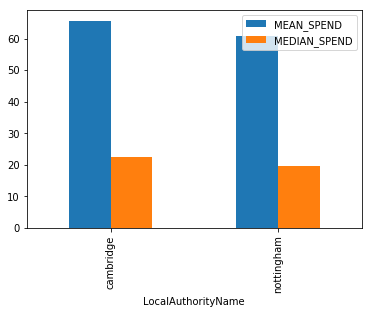

In [35]:
#Produce plot to show comparison of spend
costs=sum_presc_camb.iloc[:,[7,9]]
costs.plot(kind='bar')
plt.show()

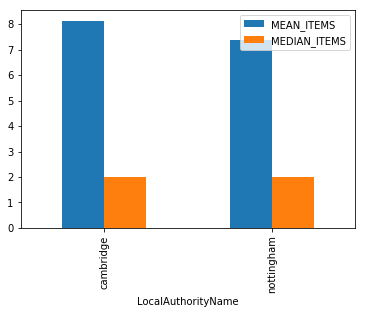

In [36]:
#Produce plot to show comparison of number of items prescribed
items=sum_presc_camb.iloc[:,[6,8]]
items.plot(kind='bar')
plt.show()

A5: Using SQL, produce a table that provides the number of GP Practices per city, ordered in descending order

In [37]:
pdsql = PandaSQL()
#SQL select query
#Q="SELECT LocalAuthorityName, COUNT(*) as 'No_GP_Practices' FROM prescribing_GP_LA GROUP BY LocalAuthorityName ORDER BY LocalAuthorityName"
#P="SELECT COUNT(*) AS NUMBER FROM prescribing_GP_LA"
print (pdsql("SELECT LocalAuthorityName, COUNT(Practice) FROM GP_Prac_LA GROUP BY LocalAuthorityName Order By LocalAuthorityName",locals()))


               LocalAuthorityName  COUNT(Practice)
0                       allerdale                5
1                    amber valley                5
2                  aylesbury vale                3
3                         babergh                4
4            barking and dagenham               21
5                          barnet               56
6                        barnsley               43
7                       bassetlaw                4
8    bath and north east somerset               32
9                          bexley               20
10                     birmingham              212
11                          blaby                7
12          blackburn with darwen               41
13                      blackpool               34
14                       bolsover                7
15                         bolton               62
16                    bournemouth               21
17                       bradford               64
18                      braintr

# Assignment B
Using the entire dataset from the HSCIC GP Practice Prescribing data, address the following queries using a combination of narrative, tables, figures and descriptive statistics:

B1: Calculate the monthly total spending for each GP-practice.

In [38]:
#Calculate monthly spend by GP Practice
monthly_spend_by_GP_Practice=pd.pivot_table(prescribing_GP_LA, values=['ACTCOST'], index=['Practice'], aggfunc='sum')


In [39]:
monthly_spend_by_GP_Practice

,ACTCOST
Practice,
a81004,147494.85
a81008,62463.90
a81009,139612.91
a81012,67075.08
a81016,135797.12
a81019,169983.53
a81020,132333.53
a81021,245131.65
a81023,106770.78


B2: Use the number of registered patients in each GP-practice to calculate the relative costs per patient.

In [44]:
#add GP Practice Name column
monthly_spend_by_GP_Practice['Practice']=monthly_spend_by_GP_Practice.index
#merge monthly spend by GP with GP Patient Demographics Dataset
relative_monthly_spend_by_GP_Practice=pd.merge(monthly_spend_by_GP_Practice, gp_patient_demographics, left_on=['Practice'], right_on=['GP_PRACTICE_CODE'], how='inner')
#add new column for relative costs
relative_monthly_spend_by_GP_Practice['Cost_Per_Patient']=relative_monthly_spend_by_GP_Practice['ACTCOST']/relative_monthly_spend_by_GP_Practice['Total_All']
relative_monthly_spend_by_GP_Practice.iloc[:,[1,53]]

,Practice,Cost_Per_Patient
0,a81004,16.117894
1,a81008,15.511274
2,a81009,15.216666
3,a81012,14.124043
4,a81016,14.101466
5,a81019,16.374485
6,a81020,16.736250
7,a81021,18.586068
8,a81023,13.913315
9,a81026,17.221311


B3: Visualize the monthly total spending per registered patients for all GP-practices in a scatterplot, show a trend line, and visualize the data for your city within the national scatterplot

(0, 60352)

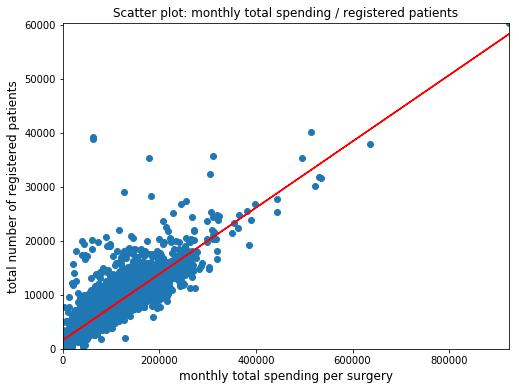

In [51]:
#Subset postcode data
#Find ONS code for Nottingham City LA and related postcodes
notts_ons_LA=postcodes[postcodes.LocalAuthorityName.str.contains('nottingham')]
#Return Nottingham postcodes as a list
notts_ons_postcode=notts_ons_LA.Postcode1.unique().tolist()

#subset the merged GP and prescribng dataset to return data related to Nottingham GP practices only
#subset GP and Nottingham postcode dataframes to identify Nottingham only practices
prescribing_notts=prescribing_GP_LA[prescribing_GP_LA.Postcode.isin(notts_ons_postcode)]
#obtain list of unique GP practice codes on Nottingham
#notts_prac_cd=prescribing_notts.Practice.unique().tolist()
#notts_rel_spend=relative_monthly_spend_by_GP_Practice(relative_monthly_spend_by_GP_Practice['Practice'].isin(notts_prac_cd))
# plot those data points
#fig, ax = plt.subplots()
fig=plt.figure(figsize=(8, 6))
ax=fig.add_subplot(111)
x= relative_monthly_spend_by_GP_Practice['ACTCOST']
y = relative_monthly_spend_by_GP_Practice['Total_All']
#s= notts_rel_spend['ACTCOST']
#t=notts_rel_spend['Total_All']
ax.scatter(x, y)
#ax.scatter(s,t,color='red')
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.set_title('Scatter plot: monthly total spending / registered patients')
ax.set_xlabel("monthly total spending per surgery",fontsize=12)
ax.set_ylabel("total number of registered patients",fontsize=12)
ax.set_xlim(0, relative_monthly_spend_by_GP_Practice['ACTCOST'].max())
ax.set_ylim(0, relative_monthly_spend_by_GP_Practice['Total_All'].max())

B4: Visualize the relative costs per patient of all national GP-practices in a histogram.

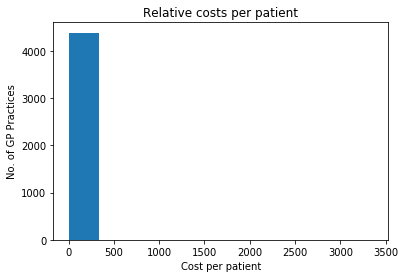

In [52]:
#plot histogram
plt.hist(relative_monthly_spend_by_GP_Practice['Cost_Per_Patient'])
plt.title("Relative costs per patient")
plt.xlabel("Cost per patient")
plt.ylabel("No. of GP Practices")

fig = plt.gcf()

B5: Use descriptive statistics to show how your assigned city compares to the national level.

In [53]:
#compare mean, median, SD, mode between city and national
sum_presc_national=pd.pivot_table(prescribing_GP_LA, values=['ACTCOST','ITEMS'], index=['CountryName'], aggfunc='sum')
sum_presc_national['LocalAuthorityName']=sum_presc_national.index
sum_presc_national['MEAN_SPEND']=relative_monthly_spend_by_GP_Practice['ACTCOST'].mean()
sum_presc_national['MEDIAN_SPEND']=relative_monthly_spend_by_GP_Practice['ACTCOST'].median()
sum_presc_national['SPEND_STD_DEV']=relative_monthly_spend_by_GP_Practice['ACTCOST'].std()
sum_presc_national['MIN_SPEND']=relative_monthly_spend_by_GP_Practice['ACTCOST'].min()


sum_presc_national = sum_presc_national.append(pd.DataFrame(sum_presc_notts, columns=['LocalAuthorityName','ACTCOST', 'ITEMS','MEAN_SPEND', 'MEDIAN_SPEND', 
   'SPEND_STD_DEV', 'MIN_SPEND', 'MAX_SPEND']),ignore_index=False)

In [54]:
sum_presc_national

,ACTCOST,ITEMS,LocalAuthorityName,MAX_SPEND,MEAN_SPEND,MEDIAN_SPEND,MIN_SPEND,SPEND_STD_DEV
england,4.124100e+08,51821077,england,NaN,92474.510739,78116.485,4.22,64009.766202
wales,3.561688e+04,4870,wales,NaN,92474.510739,78116.485,4.22,64009.766202
nottingham,3.646320e+06,440776,nottingham,7810.98,60.898878,19.620,0.04,156.037386


# Assignment C
Using the entire dataset from the HSCIC GP Practice Prescribing data, address the following queries using a combination of narrative, tables, figures and descriptive statistcs:

C1: Identify for all GP-practices the relative costs per patient for all statin prescriptions (simvastatin, atorvastatin, rosuvastatin, pravastatin, fluvastatin) by using the dataset from December 2015.

In [55]:
#enter names of prescriptions of interest
drugs=['simvastatin', 'atorvastatin', 'rosuvastatin', 'pravastatin', 'fluvastatin']
bnf_names=[]

#iterate through list of drug names to return full BNF names for each 
for i in drugs:
    drug_name=prescribing_GP_LA[prescribing_GP_LA.BNFNAME.str.contains(i)]
    bnf_names.append(drug_name.BNFNAME.unique().tolist())
    #flatten appended lists into one
    bnf_names= [val for sublist in bnf_names for val in sublist]
bnf_names
    
#all statins prescribed in December 2015
statins=prescribing_GP_LA[prescribing_GP_LA.BNFNAME.isin(bnf_names)]

#Calculate total actual cost of statins per GP Practice
statin_cost=pd.pivot_table(statins, values=['ACTCOST'], index=['Practice'], aggfunc='sum')
statin_cost['Practice']=statin_cost.index


In [56]:
statin_cost.dtypes

ACTCOST     float64
Practice     object
dtype: object

In [57]:
#merge statins costs by GP Practice with GP Demgraphics dataset
statin_cost_per_patient=pd.merge(statin_cost, gp_patient_demographics, left_on=['Practice'], right_on=['GP_PRACTICE_CODE'], how='inner')
statin_cost_per_patient=pd.merge(statin_cost_per_patient, gp_practice, left_on=['Practice'], right_on=['Practice'], how='inner')

statin_cost_per_patient.head()

,ACTCOST,Practice,GP_PRACTICE_CODE,POSTCODE,ONS_CCG_CODE,CCG_CODE,ONS_REGION_CODE,NHSE_REGION_CODE,ONS_COMM_RGN_CODE,NHSE_COMM_REGION_CODE,...,Female_85-89,Female_90-94,Female_95+,YearMonth,PracticeName,Address1,Address2,Address3,Address4,Postcode
0,2.35,a81004,a81004,ts1 3be,e38000162,00m,e39000027,q74,e40000001,y54,...,91,39,17,201512,woodlands road surgery,6 woodlands road,,middlesbrough,cleveland,ts1 3be
1,2.35,a81008,a81008,ts6 6td,e38000162,00m,e39000027,q74,e40000001,y54,...,31,11,3,201512,albert house clinic,low grange health village,normanby road,middlesbrough,cleveland,ts6 6td
2,5.58,a81009,a81009,ts5 6hf,e38000162,00m,e39000027,q74,e40000001,y54,...,63,26,12,201512,village medical centre,the village medical ctr,400/404 linthorpe road,middlesbrough,cleveland,ts5 6hf
3,2.35,a81012,a81012,ts3 6al,e38000162,00m,e39000027,q74,e40000001,y54,...,34,20,4,201512,westbourne medical centre,westbourne medical centre,7 trinity mews n. ormesby,middlesbrough,,ts3 6al
4,2.76,a81019,a81019,ts3 7rl,e38000162,00m,e39000027,q74,e40000001,y54,...,95,30,4,201512,crossfell health centre,crossfell road,berwick hills,middlesbrough,cleveland,ts3 7rl


In [58]:
statin_cost_per_patient['Cost_Per_Patient']=statin_cost_per_patient['ACTCOST']/statin_cost_per_patient['Total_All']

In [59]:
statin_cost_per_patient.dtypes

ACTCOST                  float64
Practice                  object
GP_PRACTICE_CODE          object
POSTCODE                  object
ONS_CCG_CODE              object
CCG_CODE                  object
ONS_REGION_CODE           object
NHSE_REGION_CODE          object
ONS_COMM_RGN_CODE         object
NHSE_COMM_REGION_CODE     object
Total_All                  int64
Total_Male                 int64
Total_Female               int64
Male_0-4                   int64
Male_5-9                   int64
Male_10-14                 int64
Male_15-19                 int64
Male_20-24                 int64
Male_25-29                 int64
Male_30-34                 int64
Male_35-39                 int64
Male_40-44                 int64
Male_45-49                 int64
Male_50-54                 int64
Male_55-59                 int64
Male_60-64                 int64
Male_65-69                 int64
Male_70-74                 int64
Male_75-79                 int64
Male_80-84                 int64
          

In [60]:
#statin_cost_per_patient=statin_cost_per_patient.reset_index(drop=True)
statin_cost_per_patient=statin_cost_per_patient.iloc[ :,[1,54,3,6,60]]
statin_cost_per_patient

,Practice,PracticeName,POSTCODE,ONS_REGION_CODE,Cost_Per_Patient
0,a81004,woodlands road surgery,ts1 3be,e39000027,0.000257
1,a81008,albert house clinic,ts6 6td,e39000027,0.000584
2,a81009,village medical centre,ts5 6hf,e39000027,0.000608
3,a81012,westbourne medical centre,ts3 6al,e39000027,0.000495
4,a81019,crossfell health centre,ts3 7rl,e39000027,0.000266
5,a81020,martonside medical centre,ts4 3bu,e39000027,0.002596
6,a81021,normanby medical centre,ts6 6td,e39000027,0.001225
7,a81023,the endeavour practice,ts1 2nx,e39000027,0.000360
8,a81026,the linthorpe surgery,ts5 6ha,e39000027,0.000741
9,a81030,borough road & nunthorpe medical group,ts1 3ry,e39000027,0.000454


In [61]:
#Import IMD dataset
imd=get_data('https://s3.eu-west-2.amazonaws.com/dmhr-data/deprivation-by-postcode.csv')
imd.dtypes

Postcode                               object
PostcodeStatus                         object
LSOAcode                               object
LSOAName                               object
IndexofMultipleDeprivationRank        float64
IndexofMultipleDeprivationDecile      float64
IncomeRank                            float64
IncomeDecile                          float64
IncomeScore                           float64
EmploymentRank                        float64
EmploymentDecile                      float64
EmploymentScore                       float64
EducationandSkillsRank                float64
EducationandSkillsDecile              float64
HealthandDisabilityRank               float64
HealthandDisabilityDecile             float64
CrimeRank                             float64
CrimeDecile                           float64
BarrierstoHousingandServicesRank      float64
BarrierstoHousingandServicesDecile    float64
LivingEnvironmentRank                 float64
LivingEnvironmentDecile           

In [62]:
#merge IMD with prescribing_notts on postcode
#get Nottingham GP Practices Only
gp_prac_notts=gp_practice[gp_practice.Practice.isin(notts_prac_cd)]
#merge with postcodes dataset to get LSOA
gp_prac_notts=pd.merge(gp_prac_notts, postcodes, left_on=['Postcode'], right_on=['Postcode1'], how='inner')
#merge with IMD on LSOA
gp_prac_notts_IMD=pd.merge(gp_prac_notts, imd, left_on=['LowerSuperOutputAreaCode'], right_on=['LSOAcode'], how='inner')
gp_prac_notts_IMD.drop_duplicates()
gp_prac_notts_IMD.dtypes
gp_prac_notts_IMD=gp_prac_notts_IMD.iloc[:,[2,48,49]]
gp_prac_notts_IMD

,PracticeName,IndexofMultipleDeprivationRank,IndexofMultipleDeprivationDecile
0,st albans medical centre,1572.0,1.0
1,elmswood surgery,16055.0,5.0
2,family medical centre (sood),1048.0,1.0
3,family medical centre (sood),1048.0,1.0
4,substance misuse out-reach clinics,1048.0,1.0
5,substance misuse out-reach clinics,1048.0,1.0
6,cripps health centre,20780.0,7.0
7,churchfields medical practice,4574.0,2.0
8,derby road health centre,20533.0,7.0
9,leen view surgery,1273.0,1.0


C3: Use the entire national dataset and identify the lowest relative spenders of statins from the first decile and the highest relative spenders of statins from the last decile. Now determine for all identified GP-practices for both groups (lowest and the highest) the associated Index of Multiple Deprivation (IMD). Use these two groups to assess whether the IMD-score differs. Use descriptive statistics for your answer.

In [63]:
#Assign a decile to each record based on Cost Per Patient
statin_cost_per_patient['decile']=pd.qcut(statin_cost_per_patient['Cost_Per_Patient'],10, labels=False)
#Subset the dataframe to show lowest and highest deciles of cost per patient
low_high_relative_spend=statin_cost_per_patient[statin_cost_per_patient['decile'].isin([0,9])]
low_high_relative_spend

,Practice,PracticeName,POSTCODE,ONS_REGION_CODE,Cost_Per_Patient,decile
0,a81004,woodlands road surgery,ts1 3be,e39000027,0.000257,0
4,a81019,crossfell health centre,ts3 7rl,e39000027,0.000266,0
17,a82015,warwick road surgery,ca1 1eb,e39000027,0.007286,9
25,a82030,lunesdale surgery,la6 2hq,e39000027,0.009403,9
37,a83018,consett medical centre,dh8 5ya,e39000027,0.000122,0
41,a83028,middle chare medical group,dh3 3qd,e39000027,0.000276,0
46,a83044,the horden group practice,sr8 4qp,e39000027,0.006364,9
54,a83630,denholm house,dh7 8sj,e39000027,0.007510,9
59,a85007,fell cottage surgery,ne9 5xy,e39000027,0.000281,0
63,a85021,second street surgery,ne8 2ur,e39000027,0.010511,9


In [65]:
#merge with IMD
decile_rel_spend=pd.merge(low_high_relative_spend, postcodes, left_on=['POSTCODE'], right_on=['Postcode1'], how='inner')
decile_rel_spend_imd=pd.merge(decile_rel_spend, imd, left_on=['LowerSuperOutputAreaCode'], right_on=['LSOAcode'], how='inner')
decile_rel_spend_imd.drop_duplicates()
decile_rel_spend_imd=decile_rel_spend_imd.iloc[:,[1,4,5,22,23,46,47]]

###compare 2 groups
lowest_rel_spend_imd=decile_rel_spend_imd[decile_rel_spend_imd.decile==0]
print "The mean relative spend in the lowest IMD group is", lowest_rel_spend_imd['Cost_Per_Patient'].mean()
print "The median relative spend in the lowest IMD group is", lowest_rel_spend_imd['Cost_Per_Patient'].median()
print "The relative spend in the lowest IMD group ranges from", lowest_rel_spend_imd['Cost_Per_Patient'].min(), "to", lowest_rel_spend_imd['Cost_Per_Patient'].max()
highest_rel_spend_imd=decile_rel_spend_imd[decile_rel_spend_imd.decile==9]
print "The mean relative in the highest IMD group is", highest_rel_spend_imd['Cost_Per_Patient'].mean()
print "The median relative spend in the lowest IMD group is", highest_rel_spend_imd['Cost_Per_Patient'].median()
print "The relative spend in the lowest IMD group ranges from", highest_rel_spend_imd['Cost_Per_Patient'].min(), "to", highest_rel_spend_imd['Cost_Per_Patient'].max()

The mean relative spend in the lowest IMD group is 0.000244794862779
The median relative spend in the lowest IMD group is 0.000253956569746
The relative spend in the lowest IMD group ranges from 5.20969002344e-05 to 0.00034053618971
The mean relative in the highest IMD group is 0.0118526602145
The median relative spend in the lowest IMD group is 0.00843044303195
The relative spend in the lowest IMD group ranges from 0.00609770114943 to 0.116489051095


C4:Identify for all GP-practices the associated nine English regions. Identify for each region the associated 75 mortality rate for cardiovascular diseases for the year 2015.

In [66]:
#merge gp practices and statin spend with postcode data
statin_pc=pd.merge(statin_cost_per_patient, postcodes, left_on=['POSTCODE'], right_on=['Postcode1'], how='inner')

In [67]:
#import cvd data
cvd=get_data('https://s3.eu-west-2.amazonaws.com/dmhr-data/NHSOF_1.1_I00656_D.csv')
cvd.head()

,Year,Periodofcoverage,Breakdown,Level,Leveldescription,Gender,Age,Indicatorvalue,LowerCI,UpperCI,Numerator,Denominator
0,2016,1/1/2016 to 31/12/2016,england,england,england,person,all,72.7,71.9,73.5,"33,816","50,798,600"
1,2015,1/1/2015 to 31/12/2015,england,england,england,person,all,74,73.3,74.8,"33,664","50,360,500"
2,2014,1/1/2014 to 31/12/2014,england,england,england,person,all,73.8,73,74.6,"32,895","49,941,800"
3,2013,1/1/2013 to 31/12/2013,england,england,england,person,all,76.6,75.7,77.4,"33,408","49,584,200"
4,2012,1/1/2012 to 31/12/2012,england,england,england,person,all,77.7,76.8,78.5,"33,258","49,281,700"


In [68]:
#sunset the CVD data to return the values for all genders and ages combined, per region and for 2015 only
cvd_region_2015=cvd[(cvd['Year']==2015) & (cvd['Breakdown']=='region') & (cvd['Gender']=='person') & (cvd['Age']=='all')]

In [69]:
cvd_rates_per_region=cvd_region_2015.iloc[:,[4,7,10,11]]
cvd_rates_per_region

,Leveldescription,Indicatorvalue,Numerator,Denominator
471,east midlands,76.7,"3,171","4,289,500"
472,east of england,66.3,"3,505","5,541,600"
473,london,76.7,"4,037","8,208,700"
474,north east,86,"2,000","2,399,000"
475,north west,88.3,"5,413","6,590,500"
476,south east,60.8,"4,669","8,171,900"
477,south west,64.5,"3,316","4,934,700"
478,west midlands,77.9,"3,780","5,274,400"
479,yorkshire and the humber,82.8,"3,773","4,950,200"


Q5: Visualize (using matplotlib) for each region spending for statins [x-axis] and the mortality rate [y-axis]. Assess whether relative spending for statin prescriptions in each regions correlates with the mortality rate from cardiovascular diseases.

In [70]:
#Calculate spend on statins by region
statin_spend_region=pd.pivot_table(statins, values=['ACTCOST'], index=['RegionName'],aggfunc='sum')
statin_spend_region['RegionName']=statin_spend_region.index
#merge spend and mortality data
statin_spend_mortality=pd.merge(statin_spend_region, cvd_rates_per_region,left_on=['RegionName'],right_on=['Leveldescription'],how='inner')
statin_spend_mortality['Indicatorvalue']=statin_spend_mortality['Indicatorvalue'].astype(str).astype(float)
statin_spend_mortality

,ACTCOST,RegionName,Leveldescription,Indicatorvalue,Numerator,Denominator
0,3658.01,east midlands,east midlands,76.7,"3,171","4,289,500"
1,2702.94,east of england,east of england,66.3,"3,505","5,541,600"
2,3481.24,london,london,76.7,"4,037","8,208,700"
3,892.72,north east,north east,86.0,"2,000","2,399,000"
4,4911.20,north west,north west,88.3,"5,413","6,590,500"
5,3848.49,south east,south east,60.8,"4,669","8,171,900"
6,4174.14,south west,south west,64.5,"3,316","4,934,700"
7,8047.66,west midlands,west midlands,77.9,"3,780","5,274,400"
8,4208.17,yorkshire and the humber,yorkshire and the humber,82.8,"3,773","4,950,200"


(0, 100)

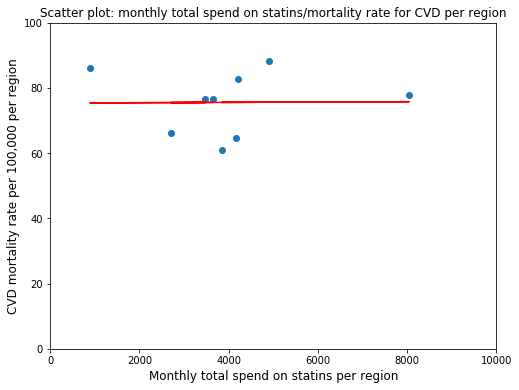

In [71]:
# plot those data points
#fig, ax = plt.subplots()
fig=plt.figure(figsize=(8, 6))
ax=fig.add_subplot(111)
x= statin_spend_mortality['ACTCOST']
y = statin_spend_mortality['Indicatorvalue']
ax.scatter(x, y)
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.set_title("Scatter plot: monthly total spend on statins/mortality rate for CVD per region")
ax.set_xlabel("Monthly total spend on statins per region",fontsize=12)
ax.set_ylabel("CVD mortality rate per 100,000 per region",fontsize=12)
ax.set_xlim(0, 10000)
ax.set_ylim(0, 100)

There is no clear linear relationship between statin spend and CVD mortality rate.

# Assignment D
Using the Google FluTrends surveillance data, pick two random countries, one in the Northern hemisphere and one in the Southern hemisphere. For each of country:

D1: Provide a visualisation of the seasonal patterns across all years.

In [72]:
#Select southern hemisphere country - Argentina
argentina=get_data('https://s3.eu-west-2.amazonaws.com/dmhr/argentina.csv')
argentina=argentina.iloc[:,[0,1]]
argentina.head()


,﻿Date,Argentina
0,02/02/2003,136
1,09/02/2003,145
2,16/02/2003,141
3,23/02/2003,135
4,02/03/2003,134


In [73]:
#Select northern hemisphere country - Russia
russia=get_data('https://s3.eu-west-2.amazonaws.com/dmhr/russia.csv')
russia.head()

,Date,Russia
0,03/10/2004,150
1,10/10/2004,168
2,17/10/2004,242
3,24/10/2004,284
4,31/10/2004,311


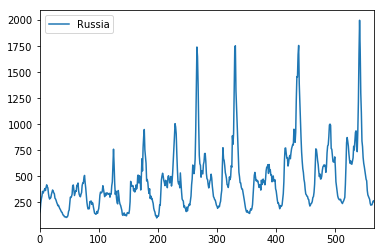

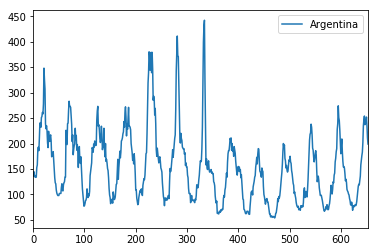

In [74]:
#plot each dataset
az=russia.plot()
az=argentina.plot()
pyplot.show()


D2: Calculate the yearly minimum and maximum for each country. Provide and plot a reasonable mathematical function that could be used as an approximation for the seasonal trend for each country.